In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchdiffeq import odeint

In [39]:
device = torch.device('cuda')

In [40]:
data_size = 1500 # number of data points
niters = 4000
batch_time = 10
batch_size = 20

## Define real system that we wish to approximate  
We want an ODE-Net to approximate the dynamical system given by the following IVP:
$$
\dot{y}=\begin{bmatrix} -0.1 & -3 \\
                        3 & -0.1\end{bmatrix}y\\
y_0 = \begin{bmatrix} 2 \\
                     0  \end{bmatrix}
$$

In the following cells, we define this system and plot the trajectories of the solution in the chosen time interval: $[0, 25]$

In [41]:
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device) # Time interval
true_A = torch.tensor([[-0.1, -3.0], [3.0, -0.1]]).to(device) # The system's matrix

Now we can define the function of the IVP, and its solution

In [42]:
class Func(nn.Module):
    
    def forward(self, t, y):
        return torch.mm(y,true_A)

In [43]:
with torch.no_grad():
    true_y = odeint(Func(), true_y0, t, method="dopri5")

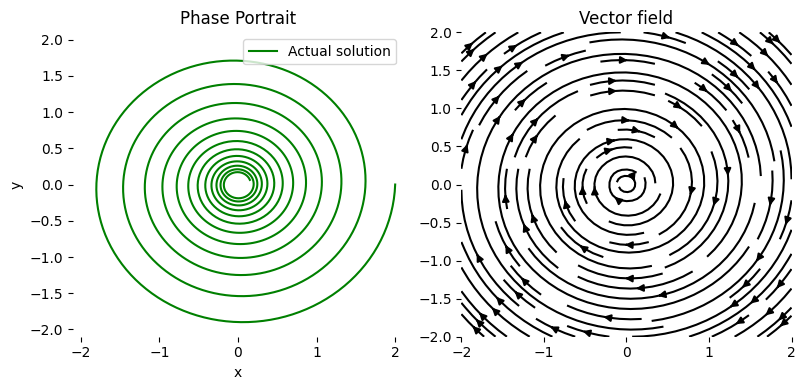

In [44]:
import matplotlib.pyplot as plt
#%matplotlib inline
with torch.no_grad():
    fig = plt.figure(figsize=(12, 4), facecolor="white")
    ax_phase = fig.add_subplot(131, frameon=False)
    ax_vecfield = fig.add_subplot(132, frameon=False)
    
    ax_phase.set_title("Phase Portrait")
    ax_phase.set_xlabel("x")
    ax_phase.set_ylabel("y")
    ax_phase.plot(true_y.cpu().numpy()[:,0, 0], true_y.cpu().numpy()[:,0, 1], 'g-', label="Actual solution")
    ax_phase.set_xlim(-2.1,2.1)
    ax_phase.set_ylim(-2.1,2.1)
    ax_phase.legend()
    
    ax_vecfield.set_title("Vector field")
    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    vf = Func().to(device)
    dydt = vf(0, torch.Tensor(np.stack([x,y], -1).reshape( 21*21, 2)).to(device)).cpu().detach().numpy()
    norm = np.sqrt(dydt[:,0]**2 + dydt[:,1]**2).reshape(-1,1)
    zero_magnitude_rows = np.where(norm == 0)[0]  
    norm[zero_magnitude_rows] = 1.0
    dydt = (dydt / norm)
    dydt = dydt.reshape(21, 21, 2)
    
    ax_vecfield.streamplot(x, y, dydt[:,:,0], dydt[:,:,1], color="black")
    ax_vecfield.set_xlim(-2,2)
    ax_vecfield.set_ylim(-2,2)

    fig.tight_layout()
    plt.draw()
    


## Define an ODE-Net to learn the previous system
We'll start by defining a Neural Network to learn the vector field of an IVP. In this simple example, it will be a single hidden layer network with a `tanh` activation function and 50 neurons. The output layer will have dimension 2 (two output neurons).

In [45]:
class NODEFunc(nn.Module):
    
    def __init__(self):
        super(NODEFunc, self).__init__()
        
        self.lin1 = nn.Linear(2, 50)
        nn.init.normal_(self.lin1.weight, mean=0, std=0.1)
        nn.init.constant_(self.lin1.weight, val=0)
        self.activation = nn.Tanh()
        
        self.out = nn.Linear(50, 2)
        nn.init.normal_(self.out.weight, mean=0, std=0.1)
        nn.init.constant_(self.out.weight, val=0)
        
    def forward(self, t, y):
        y = self.activation(self.lin1(y))
        return self.out(y)
    

Let's define auxiliary functions to create batches for training, or a visualisation function to compare predicted and actual outcomes.

In [46]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [47]:
import matplotlib.pyplot as plt
image_folder = 'learning_process'

def visualize(true_y, pred_y, odefunc, itr):
    plt.close(fig)
    fig_learn = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj_learn = fig_learn.add_subplot(131, frameon=False)
    ax_phase_learn = fig_learn.add_subplot(132, frameon=False)
    ax_vecfield_learn = fig_learn.add_subplot(133, frameon=False)

    ax_traj_learn.cla()
    ax_traj_learn.set_title('Trajectories')
    ax_traj_learn.set_xlabel('t')
    ax_traj_learn.set_ylabel('x,y')
    ax_traj_learn.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'g-', label='Actual x')
    ax_traj_learn.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'r-', label="Acutal y")
    ax_traj_learn.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', label = "Predicted x")
    ax_traj_learn.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--', label = "Predicted y")
    ax_traj_learn.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj_learn.set_ylim(-2, 2)
    ax_traj_learn.legend()

    ax_phase_learn.cla()
    ax_phase_learn.set_title('Phase Portrait')
    ax_phase_learn.set_xlabel('x')
    ax_phase_learn.set_ylabel('y')
    ax_phase_learn.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-', label = "Actual")
    ax_phase_learn.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--', label = "Predicted")
    ax_phase_learn.set_xlim(-2, 2)
    ax_phase_learn.set_ylim(-2, 2)
    ax_phase_learn.legend()

    ax_vecfield_learn.cla()
    ax_vecfield_learn.set_title('Learned Vector Field')
    ax_vecfield_learn.set_xlabel('x')
    ax_vecfield_learn.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield_learn.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield_learn.set_xlim(-2, 2)
    ax_vecfield_learn.set_ylim(-2, 2)

    fig_learn.tight_layout()
    if (itr - 1)% 75:
        plt.draw()
    plt.savefig(image_folder + f"/training_itr_{itr}.png")
    


import os
import imageio
def create_gif(gif_filename, fps=10):
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".png"):
            file_path = os.path.join(image_folder, filename)
            images.append(imageio.v2.imread(file_path))
    imageio.mimsave(gif_filename, images, fps=fps)

### Training the model

In [ ]:
# Create neural network
f_nn = NODEFunc().to(device)

# Choose an optimizer to train the model and a number of iterations
optimizer = optim.RMSprop(f_nn.parameters(), lr=1e-3)

# Create folder where images will be stored
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

for itr in range(1, niters + 1):
    optimizer.zero_grad()   # Restart gradients at zero
    batch_y0, batch_t, batch_y = get_batch()
    
    # Forward pass
    pred_y = odeint(f_nn, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.norm(pred_y-batch_y))
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred_y = odeint(f_nn, true_y0, t)
        loss = torch.mean(torch.norm(pred_y - true_y))
        if (itr - 1) % 75 == 0:
            print("Iter: {:04d}, Total loss {:.6f}".format(itr, loss.item()))
        visualize(true_y, pred_y, f_nn, itr)
        
create_gif("learning_process/learning.gif", fps=2)



Iter: 0001, Total loss 148.344940


C:\Users\Usuari\AppData\Local\Temp\ipykernel_14864\1849604859.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_learn = plt.figure(figsize=(12, 4), facecolor='white')


Iter: 0076, Total loss 58.917221
Iter: 0151, Total loss 48.173962
Iter: 0226, Total loss 19.779533
Iter: 0301, Total loss 16.864416
Iter: 0376, Total loss 16.843197
Iter: 0451, Total loss 17.207993
Iter: 0526, Total loss 15.856272
Iter: 0601, Total loss 14.342278
Iter: 0676, Total loss 14.684909
Iter: 0751, Total loss 14.967394
Iter: 0826, Total loss 12.386920
Iter: 0901, Total loss 14.459404
Iter: 0976, Total loss 11.870989
Iter: 1051, Total loss 11.976840
